✅ Data loaded — Shape: (518706, 91)


,loan_amnt,funded_amnt,term,int_rate,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
0,3000.0,3000.0,36 months,7.34,A,A4,Scale Technician,9 years,RENT,52000.0,...,0.0,0.0,0.0,191216.0,141.0,30500.0,0.0,N,Cash,N
1,5000.0,5000.0,36 months,11.98,B,B5,SDO Supervisor,10+ years,OWN,55000.0,...,33.3,1.0,0.0,61551.0,28880.0,22000.0,27751.0,N,Cash,N
2,7000.0,7000.0,36 months,11.98,B,B5,Parole,< 1 year,MORTGAGE,40000.0,...,33.3,0.0,0.0,132817.0,131726.0,10000.0,118917.0,N,Cash,N
3,30000.0,30000.0,36 months,21.85,D,D5,teacher,10+ years,OWN,57000.0,...,33.3,0.0,0.0,188780.0,62252.0,29400.0,35000.0,N,Cash,N
4,21000.0,21000.0,60 months,20.39,D,D4,Machine operator,10+ years,OWN,85000.0,...,16.7,0.0,0.0,172433.0,51667.0,27100.0,39733.0,N,Cash,N


🕵️ Target class values: [0 1]


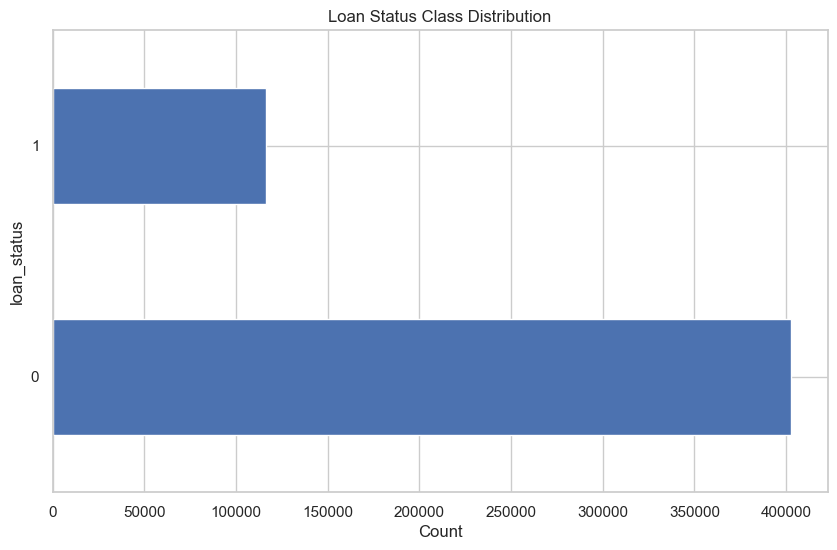

📊 Class distribution (percentage):
loan_status
0    0.776
1    0.224
Name: proportion, dtype: float64
✅ Winsorized 'dti' at 99th pct = 42.93
✅ Winsorized 'annual_inc' at 99th pct = 275,000
✅ Created log-normalized income


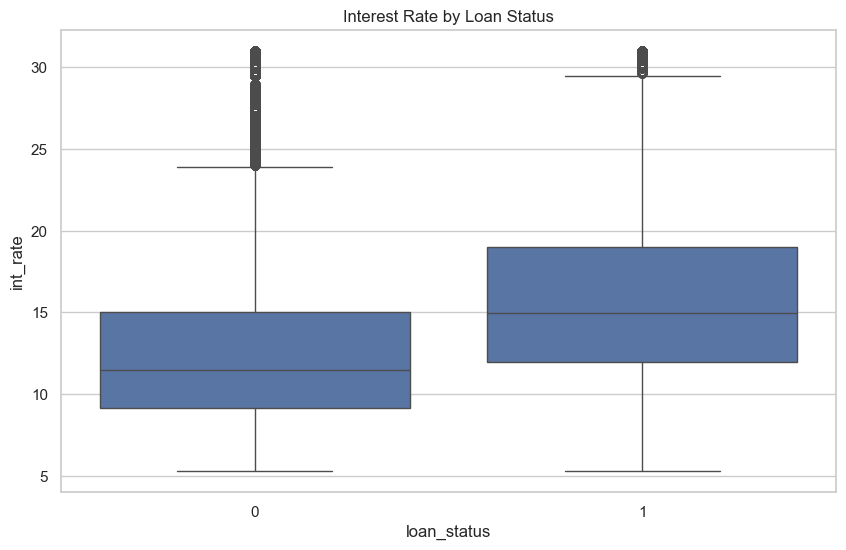

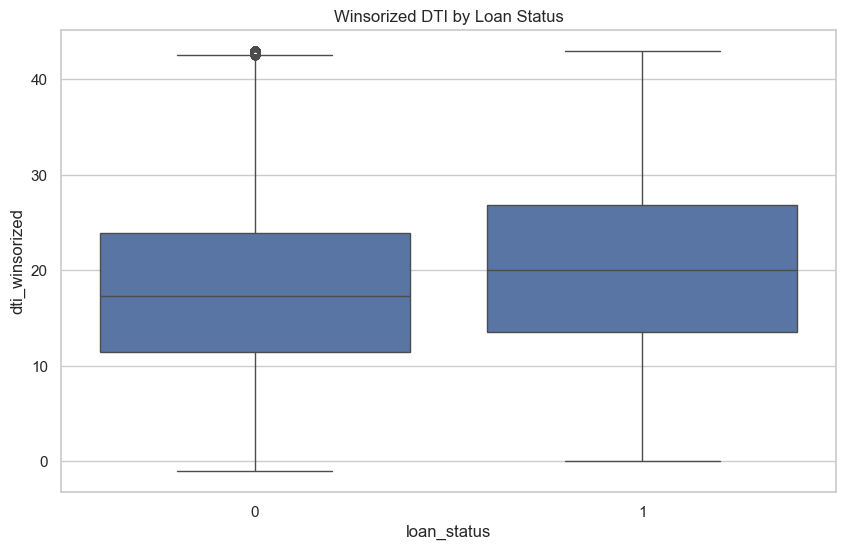

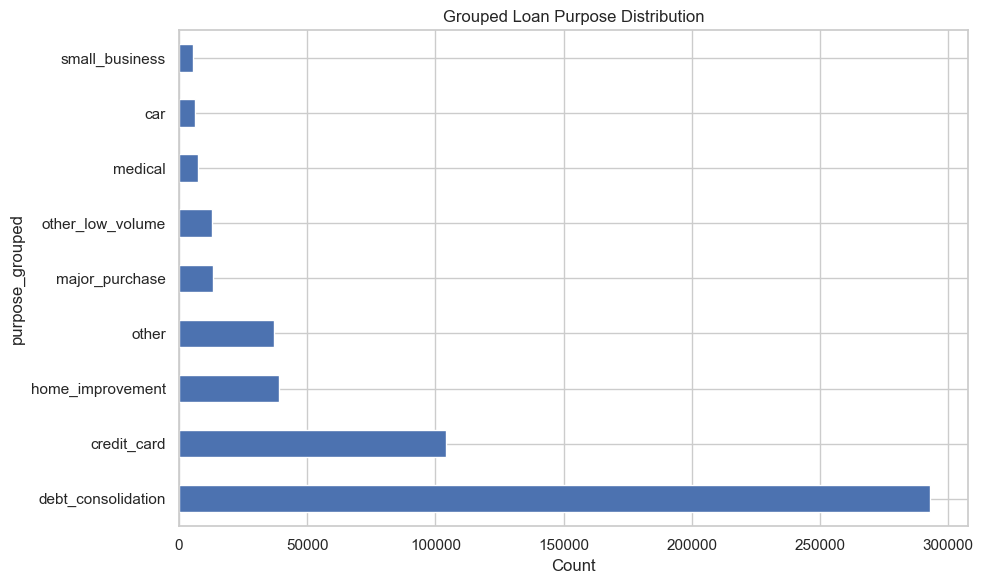

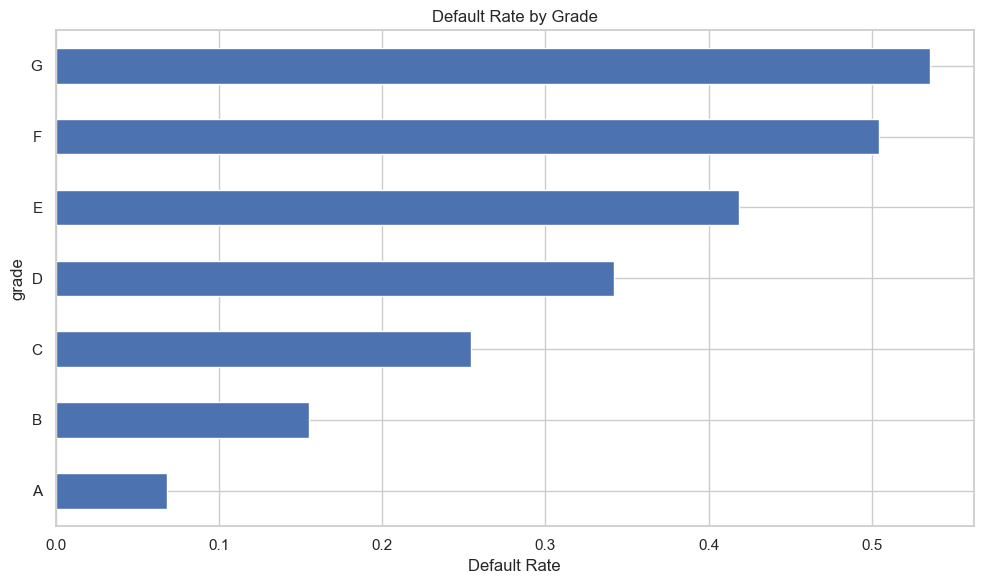

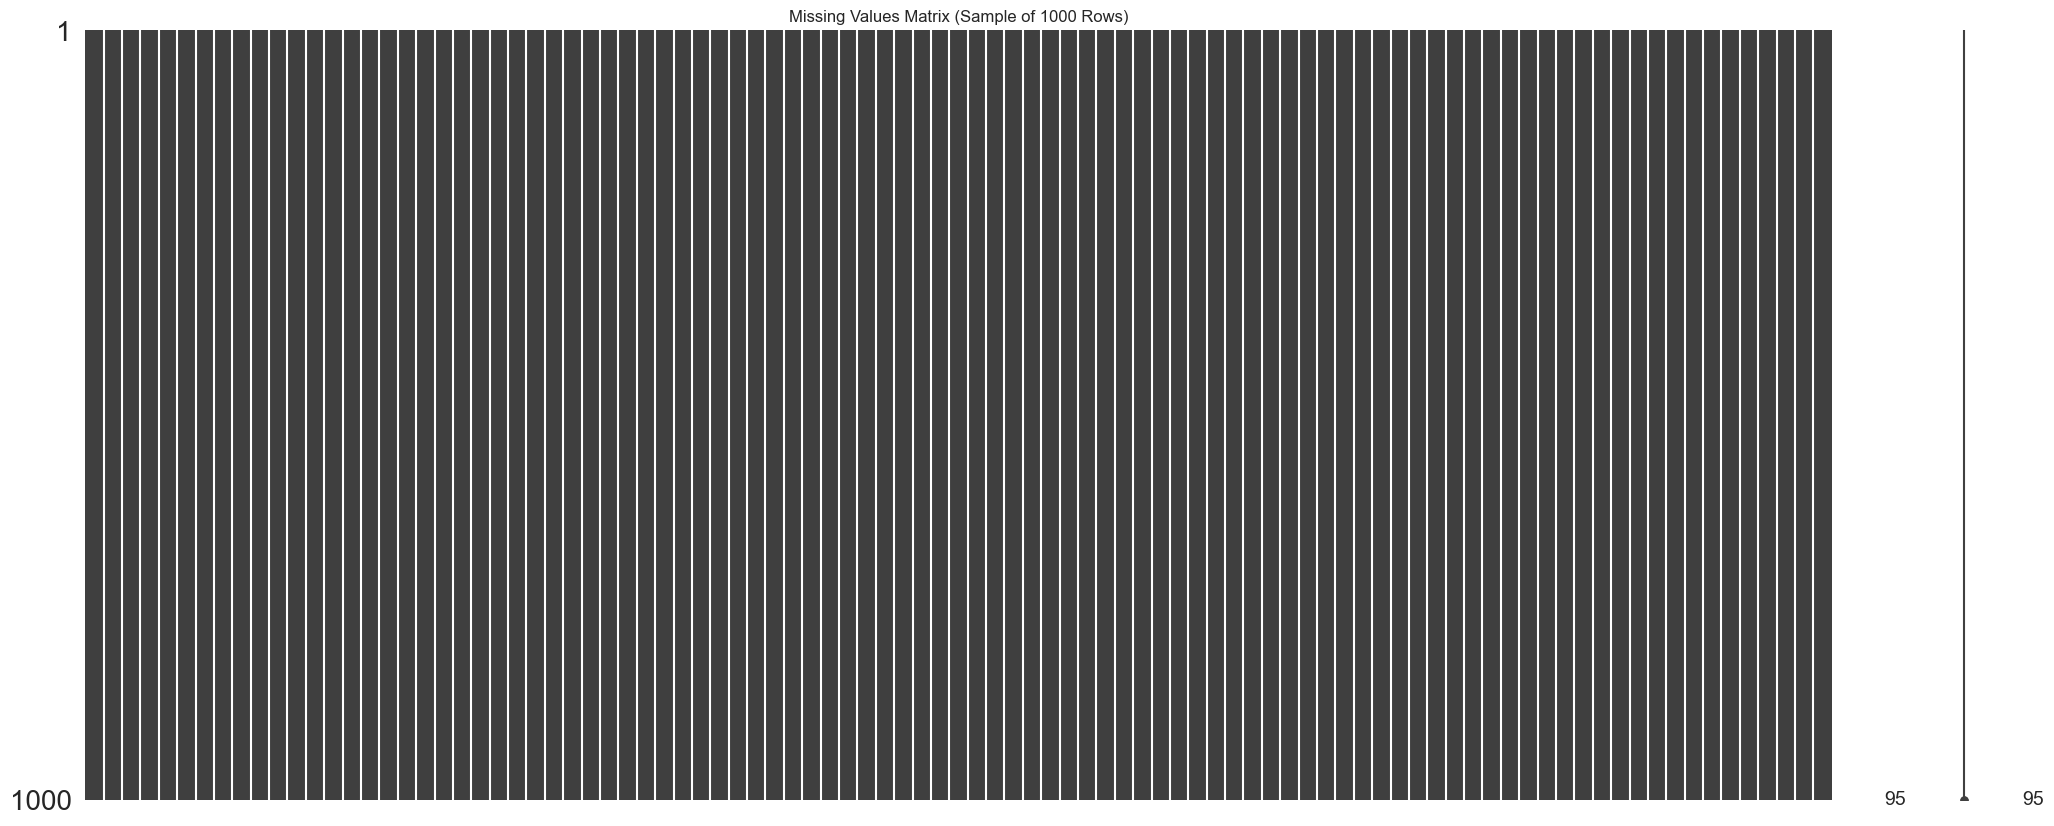

🔍 Missing values (%):
Series([], dtype: float64)
🧯 Dropped leakage cols: []
📉 Remaining columns: 95


C:\Users\Alain\AppData\Local\Temp\ipykernel_1188\2191259656.py:117: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_sizes = df.groupby(['verification_status', 'income_bin']).size().unstack()[income_order]


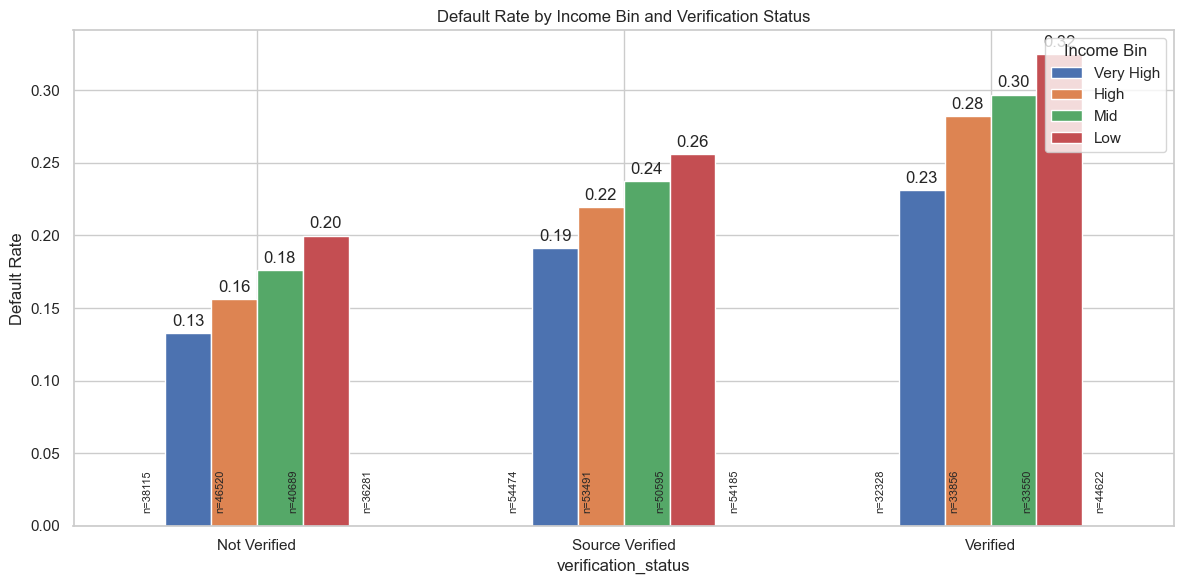

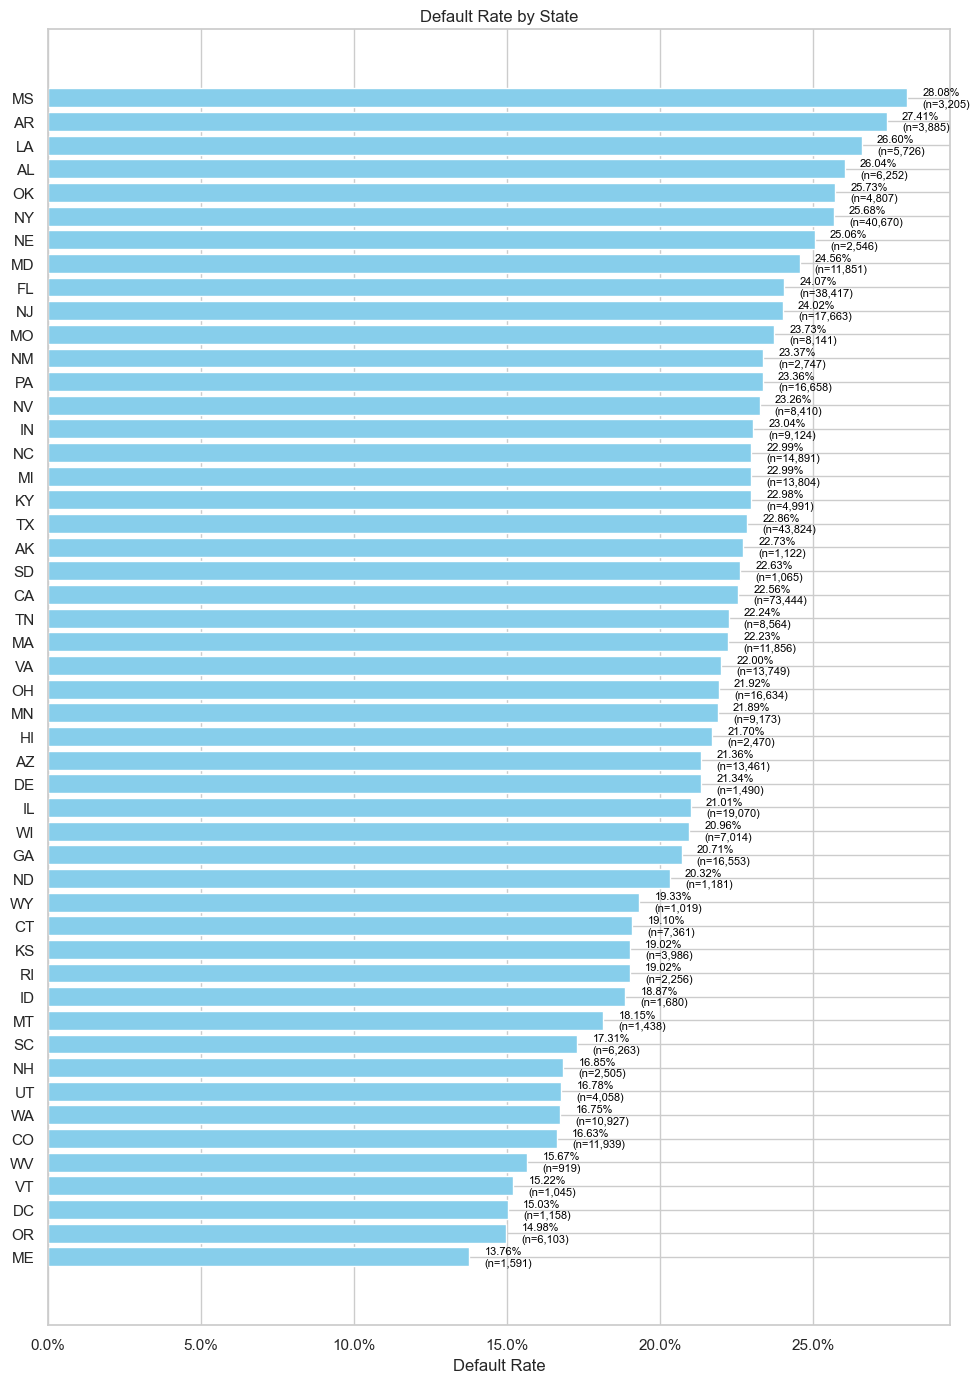

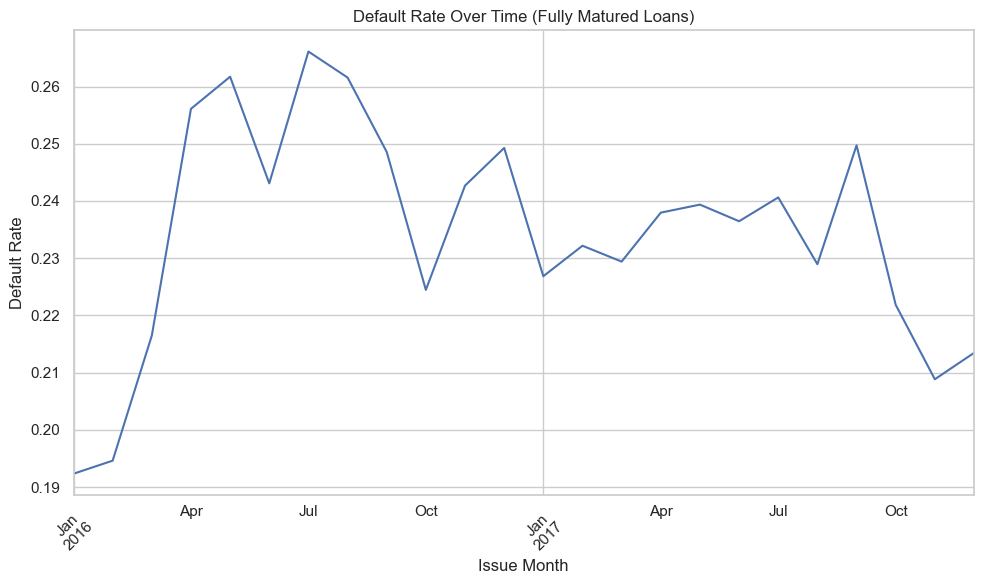

💾 Final model-ready dataset saved to: c:\Users\Alain\OneDrive\Desktop\Alain\Code Projects\borrowiq\data\processed\borrowiq_final_model_ready.csv


In [2]:
# 📦 Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import matplotlib.ticker as mtick
from pathlib import Path

# 🧭 Dynamically find project root (assumes this notebook is in 'notebooks/')
root_dir = Path.cwd().parents[0]

# 📁 Define paths
data_path = root_dir / "data" / "processed" / "borrowiq_cleaned.csv"
output_path = root_dir / "data" / "processed" / "borrowiq_final_model_ready.csv"

# Style
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# 📥 Step 2: Load Dataset
assert data_path.exists(), f"❌ File not found: {data_path}"
df = pd.read_csv(data_path)
print(f"✅ Data loaded — Shape: {df.shape}")
display(df.head())

# 🎯 Step 3: Check Target
print("🕵️ Target class values:", df['loan_status'].unique())
assert set(df['loan_status'].unique()).issubset({0, 1}), "❌ 'loan_status' must be binary (0/1)."

df['loan_status'].value_counts().plot(kind='barh', title='Loan Status Class Distribution')
plt.xlabel('Count')
plt.show()

print("📊 Class distribution (percentage):")
print(df['loan_status'].value_counts(normalize=True).round(3))

# 🧼 Step 4: Winsorize & Normalize
dti_cap = df['dti'].quantile(0.99)
df['dti_winsorized'] = df['dti'].clip(upper=dti_cap)

income_cap = df['annual_inc'].quantile(0.99)
df['annual_inc_winsorized'] = df['annual_inc'].clip(upper=income_cap)
df['annual_inc_log'] = np.log1p(df['annual_inc_winsorized'])

print(f"✅ Winsorized 'dti' at 99th pct = {dti_cap:.2f}")
print(f"✅ Winsorized 'annual_inc' at 99th pct = {income_cap:,.0f}")
print("✅ Created log-normalized income")

# 🔠 Step 5: Group Rare Purposes
purpose_counts = df['purpose'].value_counts()
threshold = df.shape[0] * 0.01
rare = purpose_counts[purpose_counts < threshold].index
df['purpose_grouped'] = df['purpose'].replace(rare, 'other_low_volume')

# 📈 Step 6: Boxplots
sns.boxplot(data=df, x='loan_status', y='int_rate')
plt.title('Interest Rate by Loan Status')
plt.show()

sns.boxplot(data=df, x='loan_status', y='dti_winsorized')
plt.title('Winsorized DTI by Loan Status')
plt.show()

# 🪪 Step 7: Categorical Overview
df['purpose_grouped'].value_counts().plot(kind='barh', title='Grouped Loan Purpose Distribution')
plt.xlabel('Count')
plt.tight_layout()
plt.show()

default_rate_by_grade = df.groupby('grade')['loan_status'].mean().sort_values()
default_rate_by_grade.plot(kind='barh', title='Default Rate by Grade')
plt.xlabel('Default Rate')
plt.tight_layout()
plt.show()

# ⚠️ Step 8: Missing Values
msno.matrix(df.sample(min(1000, len(df)), random_state=42))
plt.title("Missing Values Matrix (Sample of 1000 Rows)")
plt.show()

missing_pct = df.isnull().mean().sort_values(ascending=False)
print("🔍 Missing values (%):")
print(missing_pct[missing_pct > 0].round(3))

# 🔐 Step 9: Remove Leakage
leakage_cols = ['total_pymnt_inv', 'last_fico_range_high', 'last_fico_range_low']
to_drop = [col for col in leakage_cols if col in df.columns]
df.drop(columns=to_drop, inplace=True)
print(f"🧯 Dropped leakage cols: {to_drop}")
print(f"📉 Remaining columns: {df.shape[1]}")

# 🧠 Step 10: Rate + Grade Interactions
if df['int_rate'].nunique() > 10:
    df['int_rate_bin'] = pd.qcut(df['int_rate'], q=3, labels=['low', 'medium', 'high'])
else:
    df['int_rate_bin'] = pd.cut(df['int_rate'], bins=[0, 10, 15, np.inf], labels=['low', 'medium', 'high'])

df['int_rate_grade'] = df['grade'].astype(str) + '_' + df['int_rate_bin'].astype(str)

# 🧠 Step 11: Income × Verification Status
df['income_bin'] = pd.qcut(df['annual_inc'], 4, labels=['Low', 'Mid', 'High', 'Very High'])
income_order = ['Very High', 'High', 'Mid', 'Low']

pivot_df = pd.crosstab(df['verification_status'], df['income_bin'], 
                       values=df['loan_status'], aggfunc='mean')[income_order]

# Bar Plot: Income × Verification Status
ax = pivot_df.plot(kind='bar', figsize=(12, 6))
plt.title('Default Rate by Income Bin and Verification Status')
plt.ylabel('Default Rate')
plt.xticks(rotation=0)
plt.legend(title='Income Bin', loc='upper right')
for bars in ax.containers:
    ax.bar_label(bars, fmt='%.2f', label_type='edge', padding=3)

sample_sizes = df.groupby(['verification_status', 'income_bin']).size().unstack()[income_order]
for i, status in enumerate(pivot_df.index):
    for j, bin in enumerate(pivot_df.columns):
        size = sample_sizes.loc[status, bin]
        ax.text(i + j * 0.2 - 0.3, 0.01, f'n={size}', rotation=90, fontsize=8, ha='center')

plt.tight_layout()
plt.show()

# 🧭 Step 12: Enhanced Regional Plot
state_summary = df.groupby('addr_state')['loan_status'].agg(['mean', 'count']).sort_values('mean', ascending=False)
state_summary.rename(columns={'mean': 'default_rate', 'count': 'num_loans'}, inplace=True)

fig, ax = plt.subplots(figsize=(10, 14))
bars = ax.barh(state_summary.index, state_summary['default_rate'], color='skyblue')
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.xlabel('Default Rate')
plt.title('Default Rate by State')
ax.invert_yaxis()

for bar, rate, n in zip(bars, state_summary['default_rate'], state_summary['num_loans']):
    ax.text(rate + 0.005, bar.get_y() + bar.get_height()/2,
            f'{rate:.2%}\n(n={n:,})', va='center', fontsize=8, color='black')

plt.tight_layout()
plt.show()

# 🕒 Step 13: Time Trends (with right-censoring fix)
df['issue_d'] = pd.to_datetime(df['issue_d'], errors='coerce')
cutoff_date = df['issue_d'].max() - pd.DateOffset(months=12)
df_matured = df[df['issue_d'] <= cutoff_date]

monthly_default = df_matured.groupby(df_matured['issue_d'].dt.to_period('M'))['loan_status'].mean()

monthly_default.plot(title='Default Rate Over Time (Fully Matured Loans)')
plt.ylabel('Default Rate')
plt.xlabel('Issue Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 💾 Step 14: Save Final Dataset
output_path.parent.mkdir(parents=True, exist_ok=True)
df.to_csv(output_path, index=False)
print(f"💾 Final model-ready dataset saved to: {output_path}")
